/opt/anaconda3/envs/luke/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
/opt/anaconda3/envs/luke/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


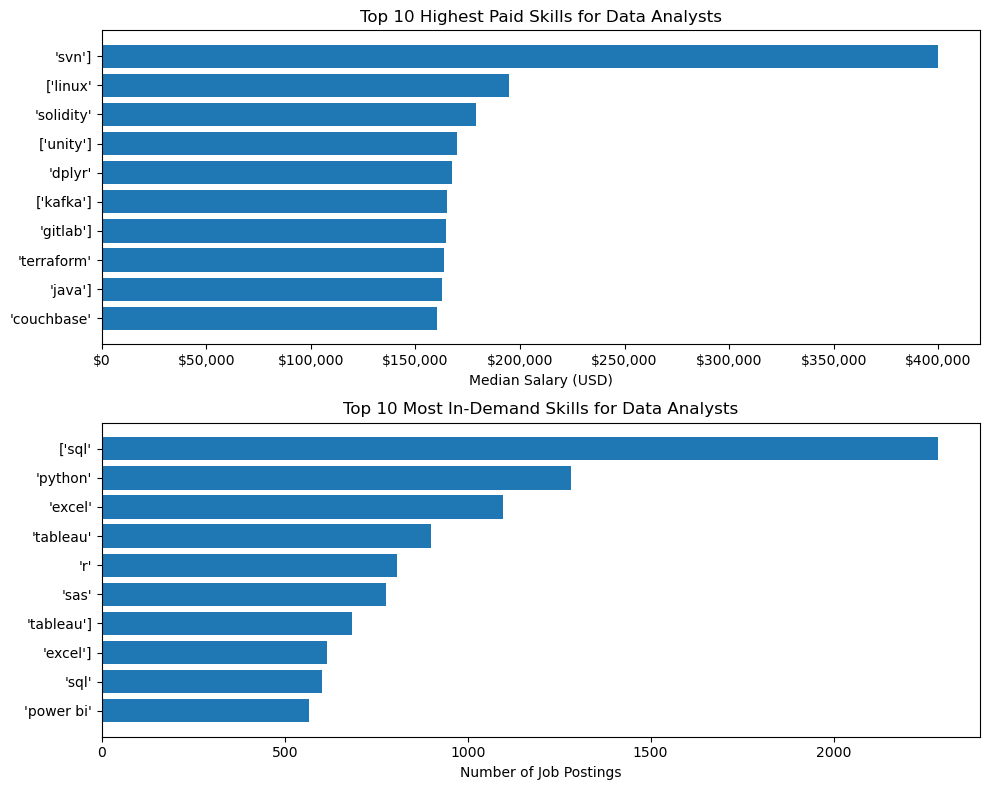

In [1]:
# --- Imports ---
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

# --- Load dataset as pandas ---
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset["train"].to_pandas()

# Ensure dates are datetime if you need time-based work later
df["job_posted_date"] = pd.to_datetime(df["job_posted_date"], errors="coerce")

# --- Focus only on Data Analyst roles and rows with yearly salary ---
da = df[(df["job_title_short"] == "Data Analyst")].copy()
da = da.dropna(subset=["salary_year_avg"])

# --- Identify the skills column (dataset uses 'job_skills') ---
skills_col_candidates = ["job_skills", "skills", "skills_list"]
skills_col = next(col for col in skills_col_candidates if col in da.columns)

# --- Normalize skills into one-skill-per-row ---
# The dataset stores skills as a comma-separated string. Handle commas/semicolons safely.
da["__skills_list__"] = (
    da[skills_col]
    .fillna("")
    .str.replace(";", ",")
    .str.split(",")
)

# Explode to long format: one row per (posting, skill)
skills_long = (
    da.explode("__skills_list__")[["__skills_list__", "salary_year_avg"]]
    .rename(columns={"__skills_list__": "skill"})
)
# Clean skill text
skills_long["skill"] = skills_long["skill"].str.strip()
skills_long = skills_long[skills_long["skill"] != ""]  # drop empties

# --- 1) Highest-paid skills (median salary) ---
top_pay = (
    skills_long.groupby("skill")["salary_year_avg"]
    .median()
    .sort_values(ascending=False)
    .head(10)
)

# --- 2) Most in-demand skills (count of postings mentioning the skill) ---
top_demand = (
    skills_long.groupby("skill")
    .size()
    .sort_values(ascending=False)
    .head(10)
)

# --- Plot ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
fig.subplots_adjust(hspace=0.35)

# Top: Highest-paid skills
axes[0].barh(top_pay.index[::-1], top_pay.values[::-1])
axes[0].set_title("Top 10 Highest Paid Skills for Data Analysts")
axes[0].set_xlabel("Median Salary (USD)")
axes[0].xaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))

# Bottom: Most in-demand skills
axes[1].barh(top_demand.index[::-1], top_demand.values[::-1])
axes[1].set_title("Top 10 Most In-Demand Skills for Data Analysts")
axes[1].set_xlabel("Number of Job Postings")

plt.tight_layout()
plt.show()
